In [1]:
import pandas as pd
import scanpy as sc
import numpy as np
import anndata as ad

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sb
#import upsetplot as usp
from matplotlib.patches import Patch
#import venn 

from sklearn.preprocessing import minmax_scale,maxabs_scale, MinMaxScaler

import diffxpy.api as de
from diffxpy.testing.det import DifferentialExpressionTestWald

from statsmodels.stats.multitest import multipletests

from scipy.cluster.hierarchy import linkage,dendrogram,fcluster,leaves_list
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

import sys
import helper as h
import importlib
importlib.reload(h)
import helper as h
#import helper_diffxpy as hde
#importlib.reload(hde)
#import helper_diffxpy as hde

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()
%load_ext rpy2.ipython

import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [2]:
%%R
library(edgeR)

In [3]:
data_folder = '/dss/dsshome1/lxc07/gobi009/data/'

In [4]:
path_human_healthy = data_folder + 'P21000/'
path_upr = data_folder + 'GSE114297/'
path_human_spikein_drug = data_folder + 'GSE142465_human/'

### Load annotations

In [5]:
# Load annotation for human healthy
adata_hh = sc.read_h5ad(path_human_healthy + 'data_annotated.h5ad')

In [6]:
hh_samples = ['114_human_islets_R266_74_years', 'HI_24', 'HI_61', 'HI_63', 'Human_Islet']

In [7]:
# Load annotation for upr
adata_upr = sc.read_h5ad(path_upr + 'data_annotated.h5ad')

In [8]:
upr_samples = ['Donor_1', 'Donor_2', 'Donor_3', 'Donor_4', 'Donor_5', 'Donor_6', 'Donor_7', 'Donor_8', 'Donor_9', 'Donor_10', 'Donor_11', 'Donor_12']

In [9]:
# Load annotation for human spikein drug
adata_hsd = sc.read_h5ad(path_human_spikein_drug + 'data_annotated.h5ad')

In [10]:
hsd_samples = ['SRR10751484', 'SRR10751489', 'SRR10751497', 'SRR10751498', 'SRR10751499', 'SRR10751500', 'SRR10751501']

### Concatenating and filtering the three data sets

In [11]:
# Concatenate the data sets
adata = ad.concat([adata_hh, adata_upr, adata_hsd])
del adata_hh
del adata_upr
del adata_hsd

In [12]:
ct_col = 'cell_type'

In [13]:
# Filter for healthy samples and beta cells
adata = adata[np.logical_and(adata.obs['file'].isin(hh_samples + upr_samples + hsd_samples), adata.obs[ct_col] == 'beta')]
adata.shape

(28806, 14977)

In [14]:
# Load metadata for the project
metadata_hh = pd.read_excel('/dss/dsshome1/lxc07/gobi009/data/scRNA-seq_pancreas_metadata.xlsx',
             sheet_name='human_healthy')
metadata_upr = pd.read_excel('/dss/dsshome1/lxc07/gobi009/data/scRNA-seq_pancreas_metadata.xlsx',
             sheet_name='UPR')
metadata_hsd = pd.read_excel('/dss/dsshome1/lxc07/gobi009/data/scRNA-seq_pancreas_metadata.xlsx',
             sheet_name='human_spikein_drug')

In [15]:
# Filter out removed samples
metadata_hh = metadata_hh[metadata_hh['sample_name'].isin(hh_samples)]
metadata_upr = metadata_upr[metadata_upr['sample_name'].isin(upr_samples)]
metadata_hsd = metadata_hsd[metadata_hsd['sample_name'].isin(hsd_samples)]

# Subset data frames to required columns
metadata_hh = metadata_hh[['sample_name', 'sex', 'age']]
metadata_upr = metadata_upr[['sample_name', 'sex', 'age']]
metadata_hsd = metadata_hsd[['sample_name', 'sex', 'age']]

# Add study name to data frames
metadata_hh['study'] = ['human_healthy' for _ in range(metadata_hh.shape[0])]
metadata_upr['study'] = ['UPR' for _ in range(metadata_upr.shape[0])]
metadata_hsd['study'] = ['human_spikein_drug' for _ in range(metadata_hsd.shape[0])]

# Concatenate data frames
metadata = pd.concat([metadata_hh, metadata_upr, metadata_hsd])

In [16]:
%%capture
# capture removes warning from anndata
# Add age, sex and study to adata.obs (renaming just for the looks)
adata.obs.rename(columns={'file': 'sample_name'}, inplace=True)
adata.obs = pd.merge(adata.obs, metadata, on='sample_name')

In [17]:
# Remove the y from the age column
#adata.obs['age'].values.reshape(-1, 1)
adata.obs['age'] = adata.obs['age'].map(lambda a: a.split(' ')[0])
#data = MinMaxScaler().fit_transform(adata.obs['age'].values.reshape(-1, 1))
adata.obs['age_norm'] = MinMaxScaler().fit_transform(adata.obs['age'].values.reshape(-1, 1))
adata.obs

,sample_name,n_counts,n_genes,mt_frac,n_counts_filter,n_genes_filter,mt_frac_filter,doublet_score,doublet,doublet_score_filter,size_factors,leiden,cell_type,cluster,cell_type_multiplet,sex,age,study,age_norm
0,HI_24,19372.0,3136,0.092350,ok,ok,ok,0.026517,0,ok,1.016746,11,beta,17,beta,female,24,human_healthy,0.038462
1,HI_24,23595.0,4477,0.116253,ok,ok,ok,0.023177,0,ok,1.757859,1,beta,6,beta,female,24,human_healthy,0.038462
2,HI_24,34922.0,4680,0.166342,ok,ok,ok,0.037197,0,ok,1.946807,4,beta,15,beta,female,24,human_healthy,0.038462
3,HI_24,30867.0,5193,0.208702,ok,ok,ok,0.022407,0,ok,2.213941,1,beta,5,beta,female,24,human_healthy,0.038462
4,HI_24,24636.0,4431,0.196866,ok,ok,ok,0.021659,0,ok,1.790378,1,beta,6,beta,female,24,human_healthy,0.038462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28801,SRR10751498,5095.0,1540,0.081452,ok,ok,ok,0.013597,0,ok,0.604041,1,beta,1_3,beta,male,37,human_spikein_drug,0.288462
28802,SRR10751498,3883.0,1473,0.056142,ok,ok,ok,0.013138,0,ok,0.594716,1,beta,1_3,beta,male,37,human_spikein_drug,0.288462
28803,SRR10751498,2354.0,990,0.149533,ok,ok,ok,0.013138,0,ok,0.337402,1,beta,1_3,beta,male,37,human_spikein_drug,0.288462
28804,SRR10751498,9055.0,2263,0.079735,ok,ok,ok,0.046291,0,ok,1.076095,1,beta,1_2,beta,male,37,human_spikein_drug,0.288462


### Create pseudobulk

In [18]:
# Normalise
adata_norm = h.get_rawnormalised(adata, sf_col='size_factors', use_log=False, use_raw=True)

/dss/dsshome1/lxc07/gobi009/miniconda3/envs/block/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [19]:
# Creat pseudobulk per sample
x_sum = []
obs_sum = []
for group, data in adata_norm.obs.groupby(['sample_name', 'age_norm', 'sex', 'study']):
    x_sum.append(np.array(adata_norm[data.index, :].X.sum(axis=0)).ravel())
    obs_sum.append({'sample':str(group[0]), 'age':str(group[1]), 'sex':str(group[2]), 'study':str(group[3])})
x_sum = pd.DataFrame(np.array(x_sum),columns=adata_norm.var_names)
obs_sum = pd.DataFrame(obs_sum)

In [20]:
print(x_sum.shape)
print(obs_sum.shape)

(24, 15022)
(24, 4)


### Differential Expression

In [21]:
group = 'sample'

In [22]:
%%R -i x_sum -i obs_sum -i group
y <- DGEList(counts=t(x_sum), samples=obs_sum)
print(dim(y))

[1] 15022    24


In [23]:
%%R
keep <- filterByExpr(y, group=y$samples[, group])
y <- y[keep, , keep.lib.sizes=FALSE]
print(dim(y))

[1] 13387    24


In [24]:
%%R
y <- calcNormFactors(y)

In [25]:
dmat_loc = pd.DataFrame(index=obs_sum.index)
dmat_loc['Intercept'] = 1

condition = 'age'
for val_idx,val in enumerate(
    sorted([cl for cl in obs_sum[condition].unique()])):
    dmat_loc.loc[obs_sum[condition]==val,condition]=val

condition = 'sex'
for val_idx,val in enumerate(
    sorted([cl for cl in obs_sum[condition].unique() if cl!='male'])):
    dmat_loc.loc[obs_sum[condition]==val,condition+'_'+str(val)]=1

dmat_loc['male:age'] = 0.0
dmat_loc['female:age'] = 0.0

for index, row in dmat_loc.iterrows():
    if dmat_loc.at[index, 'sex_female'] == 1.0:
        dmat_loc.at[index, 'female:age'] = row['age']
    else:
        dmat_loc.at[index, 'male:age'] = row['age']

condition='study'
for val_idx,val in enumerate(
    sorted([cl for cl in obs_sum[condition].unique() if cl!='UPR'])):
    dmat_loc.loc[obs_sum[condition]==val,condition+'_'+str(val)]=1
    
dmat_loc.fillna(0,inplace=True)
dmat_loc=dmat_loc.astype('float')

del(dmat_loc['age'])

print('dmat_loc')
display(dmat_loc)

dmat_loc


,Intercept,sex_female,male:age,female:age,study_human_healthy,study_human_spikein_drug
0,1.0,1.0,0.000000,1.000000,1.0,0.0
1,1.0,1.0,0.000000,0.192308,0.0,0.0
2,1.0,1.0,0.000000,0.634615,0.0,0.0
3,1.0,1.0,0.000000,0.519231,0.0,0.0
4,1.0,0.0,0.653846,0.000000,0.0,0.0
5,1.0,0.0,0.019231,0.000000,0.0,0.0
6,1.0,0.0,0.576923,0.000000,0.0,0.0
7,1.0,0.0,0.576923,0.000000,0.0,0.0
8,1.0,0.0,0.519231,0.000000,0.0,0.0
9,1.0,1.0,0.000000,0.288462,0.0,0.0


In [26]:
# Add design to R and name rows
ro.globalenv['design']=dmat_loc
ro.r('row.names(design)<-row.names(y$samples)')
ro.r('design')

,Intercept,sex_female,male:age,female:age,study_human_healthy,study_human_spikein_drug
0,1.0,1.0,0.000000,1.000000,1.0,0.0
1,1.0,1.0,0.000000,0.192308,0.0,0.0
2,1.0,1.0,0.000000,0.634615,0.0,0.0
3,1.0,1.0,0.000000,0.519231,0.0,0.0
4,1.0,0.0,0.653846,0.000000,0.0,0.0
5,1.0,0.0,0.019231,0.000000,0.0,0.0
6,1.0,0.0,0.576923,0.000000,0.0,0.0
7,1.0,0.0,0.576923,0.000000,0.0,0.0
8,1.0,0.0,0.519231,0.000000,0.0,0.0
9,1.0,1.0,0.000000,0.288462,0.0,0.0


In [27]:
%%R
# Robust dispersion 
y <- estimateGLMRobustDisp(y, design)

In [28]:
%%R
# Fit - GLM not QL as used robust dispersion
fit <- glmFit(y, design)

In [29]:
%R fit$design

array([[1.        , 1.        , 0.        , 1.        , 1.        ,
        0.        ],
       [1.        , 1.        , 0.        , 0.19230769, 0.        ,
        0.        ],
       [1.        , 1.        , 0.        , 0.63461538, 0.        ,
        0.        ],
       [1.        , 1.        , 0.        , 0.51923077, 0.        ,
        0.        ],
       [1.        , 0.        , 0.65384615, 0.        , 0.        ,
        0.        ],
       [1.        , 0.        , 0.01923077, 0.        , 0.        ,
        0.        ],
       [1.        , 0.        , 0.57692308, 0.        , 0.        ,
        0.        ],
       [1.        , 0.        , 0.57692308, 0.        , 0.        ,
        0.        ],
       [1.        , 0.        , 0.51923077, 0.        , 0.        ,
        0.        ],
       [1.        , 1.        , 0.        , 0.28846154, 0.        ,
        0.        ],
       [1.        , 0.        , 0.32692308, 0.        , 0.        ,
        0.        ],
       [1.        , 0

In [30]:
sex = ro.r('glmLRT(fit, coef=2)$table')
sex['padj'] = multipletests(sex["PValue"].values, alpha=0.05, method='fdr_bh')[1]
sex['-log_padj'] = -np.log10(sex['padj'])
sex['marked'] = sex.index == 'DEFB4A'
sex.sort_values(['padj'])
#sex.sort_values(['logFC'], ascending=0)

,logFC,logCPM,LR,PValue,padj,-log_padj,marked
RPS4Y1,-13.479531,8.768376,3.997640e+02,6.198777e-89,8.298303e-85,84.081011,False
EIF1AY,-13.641802,6.001890,2.218136e+02,3.637454e-50,2.434730e-46,45.613549,False
USP9Y,-11.796125,4.012115,1.828330e+02,1.166501e-41,3.903986e-38,37.408492,False
DDX3Y,-11.774579,3.413427,1.831401e+02,9.996424e-42,3.903986e-38,37.408492,False
UTY,-10.784661,1.976054,7.795287e+01,1.055287e-18,2.825425e-15,14.548916,False
...,...,...,...,...,...,...,...
PSMA1,-0.000149,7.440011,2.644097e-07,9.995897e-01,9.999518e-01,0.000021,False
FAM199X,0.000376,3.144288,4.932130e-07,9.994397e-01,9.999518e-01,0.000021,False
EWSR1,0.000011,6.282522,7.869936e-10,9.999776e-01,1.000000e+00,-0.000000,False
SPRR2A,-7.126283,-2.452130,1.647348e-08,9.998976e-01,1.000000e+00,-0.000000,False


In [31]:
male_age = ro.r('glmLRT(fit, coef=3)$table')
male_age['padj'] = multipletests(male_age["PValue"].values, alpha=0.05, method='fdr_bh')[1]
male_age['-log_padj'] = -np.log10(male_age['padj'])
male_age['marked'] = male_age.index == 'DEFB4A'
male_age.sort_values(['padj'])

,logFC,logCPM,LR,PValue,padj,-log_padj,marked
UHRF1,-11.141318,-1.988789,3.529532e+01,2.833116e-09,0.000038,4.421052,False
SERPINE2,-4.128552,4.258407,3.353118e+01,7.013063e-09,0.000047,4.328439,False
DEFB4A,-24.471231,-0.799264,2.977514e+01,4.851730e-08,0.000199,3.701662,True
CTU1,-6.325748,1.340780,2.938320e+01,5.939021e-08,0.000199,3.701662,False
MAP2K2,-3.326518,4.266949,2.646019e+01,2.690253e-07,0.000720,3.142494,False
...,...,...,...,...,...,...,...
SRGAP2C,0.000146,3.432173,6.904236e-08,9.997903e-01,1.000000,-0.000000,False
VAMP2,0.000149,8.578798,1.364435e-07,9.997053e-01,1.000000,-0.000000,False
CEP41,0.000139,3.901987,9.953958e-08,9.997483e-01,1.000000,-0.000000,False
ARHGEF12,0.000351,4.003873,4.550600e-07,9.994618e-01,1.000000,-0.000000,False


In [32]:
female_age = ro.r('glmLRT(fit, coef=4)$table')
female_age['padj'] = multipletests(female_age["PValue"].values, alpha=0.05, method='fdr_bh')[1]
female_age['-log_padj'] = -np.log10(female_age['padj'])
female_age['marked'] = female_age.index == 'DEFB4A'
female_age.sort_values(['padj'])

,logFC,logCPM,LR,PValue,padj,-log_padj,marked
DEFB4A,4.863033,-0.799264,35.399864,2.685057e-09,0.000036,4.444363,True
GTSF1,-6.912746,-1.983178,31.849754,1.665708e-08,0.000111,3.952748,False
LDHA,2.164651,4.025231,23.242377,1.428154e-06,0.006373,2.195663,False
HMOX1,2.443431,3.087002,21.181013,4.178840e-06,0.008081,2.092539,False
AC011043.1,-5.301635,5.050690,20.985029,4.628863e-06,0.008081,2.092539,False
...,...,...,...,...,...,...,...
CERCAM,0.000819,3.399265,0.000004,9.985033e-01,1.000000,-0.000000,False
ZBTB21,-0.001902,2.308326,0.000013,9.971126e-01,1.000000,-0.000000,False
SLC25A25,-0.001551,2.768012,0.000020,9.964470e-01,1.000000,-0.000000,False
SHISA5,0.001798,5.048464,0.000040,9.949721e-01,1.000000,-0.000000,False


In [33]:
male_age_vs_female_age = ro.r('glmLRT(fit, contrast=c(0, 0, -1, 1, 0, 0))$table')
male_age_vs_female_age['padj'] = multipletests(male_age_vs_female_age["PValue"].values, alpha=0.05, method='fdr_bh')[1]
male_age_vs_female_age['-log_padj'] = -np.log10(male_age_vs_female_age['padj'])
male_age_vs_female_age['marked'] = male_age_vs_female_age.index == 'DEFB4A'
male_age_vs_female_age.sort_values(['padj'])

,logFC,logCPM,LR,PValue,padj,-log_padj,marked
DEFB4A,29.334264,-0.799264,33.218833,8.234910e-09,0.000110,3.957658,True
SERPINE2,5.157963,4.258407,31.759592,1.744854e-08,0.000117,3.932588,False
ITIH5,6.464418,1.127703,25.638421,4.117589e-07,0.001837,2.735795,False
VIPR2,12.561255,-2.695924,24.550532,7.238637e-07,0.002423,2.615720,False
CTU1,6.999425,1.340780,23.359472,1.343801e-06,0.003598,2.443952,False
...,...,...,...,...,...,...,...
AFG1L,-0.651236,1.298256,0.519555,4.710316e-01,1.000000,-0.000000,False
FOXO3,-1.166609,3.665569,2.858900,9.086959e-02,1.000000,-0.000000,False
ARMC2,0.204652,1.226218,0.055946,8.130221e-01,1.000000,-0.000000,False
MTRES1,-0.213321,4.883582,0.198229,6.561540e-01,1.000000,-0.000000,False


### Analyse results

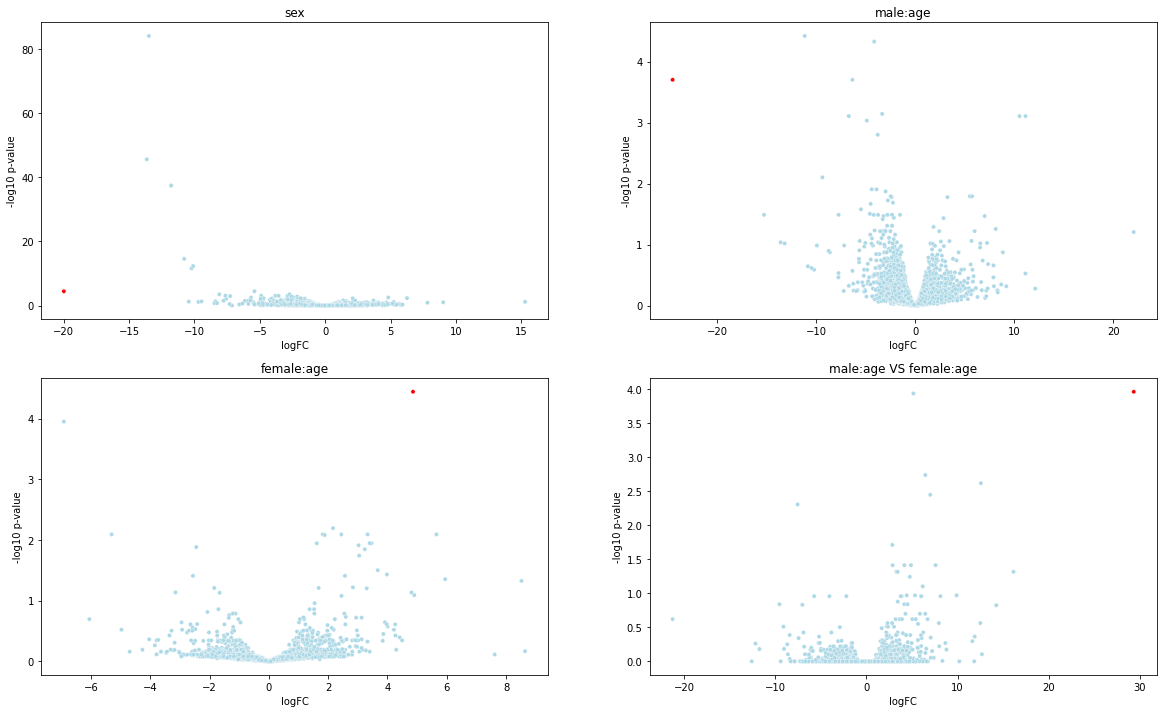

In [35]:
fig = plt.figure(figsize=(20,12))

pal = ['lightblue', 'red']

ax1 = plt.subplot(2, 2, 1)
sb.scatterplot(x='logFC', y='-log_padj', data=sex, size=2, palette=pal, hue='marked', legend=False)
ax1.set_title('sex')

ax2 = plt.subplot(2, 2, 2)
sb.scatterplot(x='logFC', y='-log_padj', data=male_age, size=2, palette=pal, hue='marked', legend=False)
ax2.set_title('male:age')

ax3 = plt.subplot(2, 2, 3)
sb.scatterplot(x='logFC', y='-log_padj', data=female_age, size=2, palette=pal, hue='marked', legend=False)
ax3.set_title('female:age')

ax4 = plt.subplot(2, 2, 4)
sb.scatterplot(x='logFC', y='-log_padj', data=male_age_vs_female_age, size=2, palette=pal, hue='marked', legend=False)
ax4.set_title('male:age VS female:age')

ax1.set_ylabel('-log10 p-value')
ax2.set_ylabel('-log10 p-value')
ax3.set_ylabel('-log10 p-value')
ax4.set_ylabel('-log10 p-value')

plt.show()